In [1]:
import warnings; warnings.filterwarnings('ignore')

import itertools
import time
import numpy as np
from pprint import pprint

from collections import defaultdict

import gymnasium as gym
from gridworld.envs import SiblingGridWorldEnv
from gymnasium.envs.registration import register
from gymnasium.wrappers import TimeLimit
from tabulate import tabulate
import tqdm as tqdm

import random
import matplotlib
import matplotlib.pyplot as plt
SEEDS = (12, 34, 56, 78, 90)

%matplotlib inline

from utils import *
from sibling_gw_agent import SiblingGWAgent

In [2]:
plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
plt.rcParams.update(params)
np.set_printoptions(precision=3, suppress=True)

In [3]:
def sibling():
    env = SiblingGridWorldEnv(P_gridworld)
    env = TimeLimit(env, max_episode_steps=100)
#     env = RelativePositionenv)
    return env

register(
    id='SiblingGridWorld-v0',
    entry_point=sibling,
    max_episode_steps=100,
)

env = gym.make('SiblingGridWorld-v0')
env = env.unwrapped
# env.render_mode = 'human'
obs, info = env.reset()

In [4]:
n_episodes = 20_000
agent = SiblingGWAgent(env, min_epsilon=0.1, epsilon_decay_ratio=0.9, n_episodes=n_episodes)
# agent = SiblingGWAgent(env, min_epsilon=0.5, epsilon_decay_ratio=0.9, n_episodes=n_episodes)
# agent.episode = 5000
# agent.epsilons[agent.episode]

In [5]:
print(obs)
agent.select_action(obs)

[ 3  4 11]


85

In [6]:
for episode in tqdm(range(agent.episode, agent.episode + n_episodes)):
    agent.episode = episode
    state, info = env.reset()
    done = False
    while not done:
        action = agent.select_action(state)
        action = np.unravel_index(action, env.action_space.nvec, order='F')
        next_state, reward, terminated, truncated, info = agent.env.step(action)
        
        # update the agent
        agent.update(state, action, reward, terminated, next_state)

        # update if the environment is done or truncated
        done = terminated or truncated
        state = next_state

100%|██████████| 20000/20000 [01:16<00:00, 262.38it/s]


In [7]:
# env.render_mode = 'human'
obs, info = env.reset()
obs

array([ 4,  0, 19])

In [8]:
rng = np.random.default_rng()
env.render_mode = None
obs, info = env.reset()
env._agent_location = np.array([2, 2])
obs[:-1] = env._agent_location
avg_steps = 100
alpha = 0.1
running_avg = [10]
max_ep_len = 100
for e in tqdm(range(1, 1_000)):
    for i in range(1, max_ep_len):
        obs_idx = np.ravel_multi_index(obs, env.observation_space.nvec, order='F')
        action = np.argmax(agent.Q[obs_idx])
        action = np.unravel_index(action, env.action_space.nvec, order='F')

        # # Trying out the vanilla greedy
        # P = agent.env._update_P(0)
        # Q_gw, V_gw, pi_gw = value_iteration(P)
        # loc_idx = np.ravel_multi_index(obs[:-1], agent.env.observation_space.nvec[:-1], order='F')
        # action = np.array([pi_gw(loc_idx), action[-1]])

        obs, rew, done, trunc, info = env.step(action)
        # print(obs, rew, info)
        # time.sleep(0.05)
        if done or i == max_ep_len - 1:
            # print(f"Finished in {i} steps.")
            avg_steps += 1/e * (i - avg_steps)
            running_avg += [(1-alpha) * running_avg[-1] + alpha * avg_steps]
            break
    obs, info = env.reset()
    env._agent_location = np.array([2, 2])
    obs[:-1] = env._agent_location
    # if e % 100 == 0:
    #     print(f"Episode {e} finished, current average estimate is {avg_steps}.")

print(f"Cumulative average estimate: {avg_steps}")

100%|██████████| 999/999 [00:01<00:00, 574.97it/s]

Cumulative average estimate: 4.354354354354353


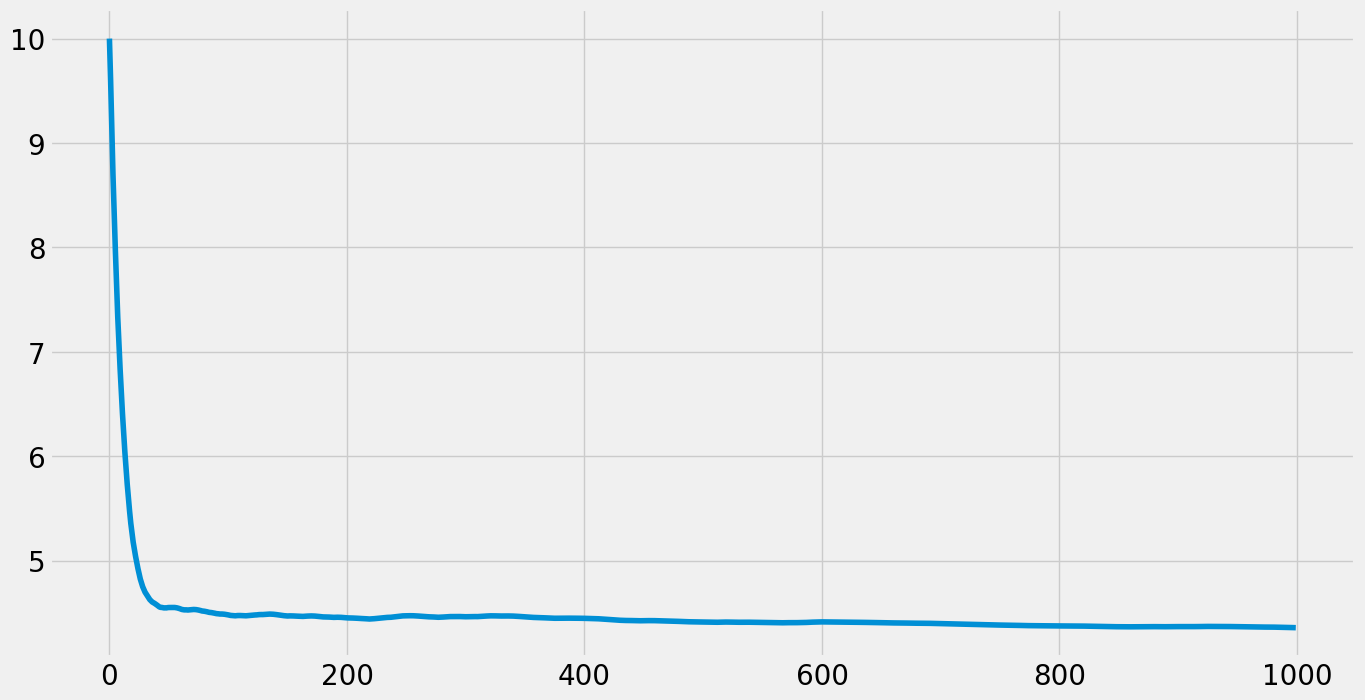

In [9]:
plt.plot(running_avg)

In [10]:
state = np.array([2, 2, 11])
state_idx = np.ravel_multi_index(state, env.observation_space.nvec, order='F')
print(state_idx, agent.Q[state_idx].max(), np.argmax(agent.Q[state_idx]))

287 0.006558444107911145 3


In [11]:
env.render_mode = 'human'
obs, info = env.reset()
env._agent_location = np.array([2, 2])
obs[:-1] = env._agent_location
# print(np.concatenate([env._agent_location, env._world_belief]))
env._render_frame()
time.sleep(0.5)
for i in range(1,max_ep_len):
    obs_idx = np.ravel_multi_index(obs, env.observation_space.nvec, order='F')
    action_linear = np.argmax(agent.Q[obs_idx])
    action = np.unravel_index(action_linear, env.action_space.nvec, order='F')
    # print(obs_idx, np.concatenate([env._agent_location, env._world_belief]), action_linear, action, agent.Q[obs_idx].max())
    obs, rew, done, trunc, info = env.step(action)
    print(obs, rew, info)
    time.sleep(0.05)
    if done:
        print(f"Finished in {i} steps.")
        break

[ 2  3 21] -0.6000000000000001 {'distance': 3.0}
[3 3 0] -0.20000000000000007 {'distance': 2.0}
[4 3 0] -0.20000000000000007 {'distance': 1.0}
[4 4 0] 0.8 {'distance': 0.0}
Finished in 4 steps.


In [12]:
# env.close()